# Road Test

In [1]:
import emat
emat.versions()

emat 0.2.7, ema_workbench 2.1.507, plotly 4.2.1


In [2]:
import ema_workbench
import os, numpy, pandas, functools

In [3]:
logger = emat.util.loggers.log_to_stderr(20, True)

## Defining the Exploratory Scope

In [4]:
road_test_scope_file = emat.package_file('model','tests','road_test.yaml')

In [5]:
road_scope = emat.Scope(road_test_scope_file)
road_scope

<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>

A short summary of the scope can be reviewed using the `info` method.

In [6]:
road_scope.info()

name: EMAT Road Test
desc: prototype run
constants:
  free_flow_time = 60
  initial_capacity = 100
uncertainties:
  alpha = 0.1 to 0.2
  beta = 3.5 to 5.5
  input_flow = 80 to 150
  value_of_time = 0.001 to 0.25
  unit_cost_expansion = 95.0 to 145.0
  interest_rate = 0.025 to 0.04
  yield_curve = -0.0025 to 0.02
levers:
  expand_capacity = 0.0 to 100.0
  amortization_period = 15 to 50
  debt_type = categorical
  interest_rate_lock = boolean
measures:
  no_build_travel_time
  build_travel_time
  time_savings
  value_of_time_savings
  net_benefits
  cost_of_capacity_expansion
  present_cost_expansion


Alternatively, more detailed information about each part of the scope can be
accessed in four list attributes:

In [7]:
road_scope.get_constants()

[Constant('free_flow_time', 60), Constant('initial_capacity', 100)]

In [8]:
road_scope.get_uncertainties()

[<emat.RealParameter 'alpha'>,
 <emat.RealParameter 'beta'>,
 <emat.IntegerParameter 'input_flow'>,
 <emat.RealParameter 'value_of_time'>,
 <emat.RealParameter 'unit_cost_expansion'>,
 <emat.RealParameter 'interest_rate'>,
 <emat.RealParameter 'yield_curve'>]

In [9]:
road_scope.get_levers()

[<emat.RealParameter 'expand_capacity'>,
 <emat.IntegerParameter 'amortization_period'>,
 <emat.CategoricalParameter 'debt_type'>,
 <emat.BooleanParameter 'interest_rate_lock'>]

In [10]:
road_scope.get_measures()

[Measure('no_build_travel_time'),
 Measure('build_travel_time'),
 Measure('time_savings'),
 Measure('value_of_time_savings'),
 Measure('net_benefits'),
 Measure('cost_of_capacity_expansion'),
 Measure('present_cost_expansion')]

## Using a Database

The exploratory modeling process will typically generate many different sets of outputs,
for different explored modeling scopes, or for different applications.  It is convenient
to organize these outputs in a database structure, so they are stored consistently and 
readily available for subsequent analysis.

The `SQLiteDB` object will create a database to store results.  When instantiated with
no arguments, the database is initialized in-memory, which will not store anything to
disk (which is convenient for this example, but in practice you will generally want to
store data to disk so that it can persist after this Python session ends).

In [11]:
emat_db = emat.SQLiteDB()

[00:04.36] MainProcess/INFO: running script scope.sql
[00:04.36] MainProcess/INFO: running script exp_design.sql
[00:04.36] MainProcess/INFO: running script meta_model.sql


An EMAT Scope can be stored in the database, to provide needed information about what the 
various inputs and outputs represent.

In [12]:
road_scope.store_scope(emat_db)

Trying to store another scope with the same name (or the same scope) raises a KeyError.

In [13]:
try:
    road_scope.store_scope(emat_db)
except KeyError as err:
    print(err)

'scope named "EMAT Road Test" already exists'


We can review the names of scopes already stored in the database using the `read_scope_names` method.

In [14]:
emat_db.read_scope_names()

['EMAT Road Test']

## Experimental Design

Actually running the model can be done by the user on an *ad hoc* basis (i.e., manually defining every 
combination of inputs that will be evaluated) but the real power of EMAT comes from runnning the model
using algorithm-created experimental designs.

An important experimental design used in exploratory modeling is the Latin Hypercube.  This design selects
a random set of experiments across multiple input dimensions, to ensure "good" coverage of the 
multi-dimensional modeling space.

The `design_latin_hypercube` function creates such a design based on a `Scope`, and optionally
stores the design of experiments in a database.

In [15]:
from emat.experiment.experimental_design import design_experiments

In [16]:
design = design_experiments(road_scope, db=emat_db, n_samples_per_factor=10, sampler='lhs')
design.head()

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
experiment,,,,,,,,,,,,,
1,0.184682,38,5.237143,Rev Bond,18.224793,115,0.031645,False,118.213466,0.059510,0.015659,60,100
2,0.166133,36,4.121963,Paygo,87.525790,129,0.037612,True,141.322696,0.107772,0.007307,60,100
3,0.198937,44,4.719838,GO Bond,45.698048,105,0.028445,False,97.783320,0.040879,-0.001545,60,100
4,0.158758,42,4.915816,GO Bond,51.297546,113,0.036234,True,127.224901,0.182517,0.004342,60,100
5,0.157671,42,3.845952,Paygo,22.824149,133,0.039257,False,107.820482,0.067102,0.001558,60,100


In [17]:
large_design = design_experiments(road_scope, db=emat_db, n_samples=5000, sampler='lhs', design_name='lhs_large')
large_design.head()

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
experiment,,,,,,,,,,,,,
111,0.154130,21,5.061648,Rev Bond,75.542217,112,0.029885,True,124.452736,0.056335,0.001425,60,100
112,0.148731,29,4.088663,Rev Bond,91.184595,145,0.028659,False,131.688623,0.051854,0.007850,60,100
113,0.124027,34,3.956884,Paygo,60.436585,80,0.038101,False,95.462532,0.045672,0.011101,60,100
114,0.129724,41,4.969628,Paygo,74.271040,139,0.029665,False,98.206495,0.044312,0.010072,60,100
115,0.185723,22,4.485432,Paygo,61.084166,95,0.039195,False,140.792308,0.144629,0.019277,60,100


We can review what experimental designs have already been stored in the database using the 
`read_design_names` method of the `Database` object.

In [18]:
emat_db.read_design_names('EMAT Road Test')

['lhs', 'lhs_large']

## Core Model in Python

### Model Definition

In the simplest approach for EMAT, a model can be defined as a basic Python function, which accepts all
inputs (exogenous uncertainties, policy levers, and externally defined constants) as named keyword
arguments, and returns a dictionary where the dictionary keys are names of performace measures, and 
the mapped values are the computed values for those performance measures.  The `Road_Capacity_Investment`
function provided in EMAT is an example of such a function.  This made-up example considers the 
investment in capacity expansion for a single roadway link.  The inputs to this function are described
above in the Scope, including uncertain parameters in the volume-delay function,
traffic volumes, value of travel time savings, unit construction costs, and interest rates, and policy levers including the 
amount of capacity expansion and amortization period.

In [19]:
from emat.model.core_python import PythonCoreModel, Road_Capacity_Investment

In [20]:
m = PythonCoreModel(Road_Capacity_Investment, scope=road_scope, db=emat_db)

### Model Execution

In [21]:
lhs_results = m.run_experiments(design_name='lhs')
lhs_results.head()

[00:06.26] MainProcess/INFO: performing 110 scenarios/policies * 1 model(s) = 110 experiments
[00:06.27] MainProcess/INFO: performing experiments sequentially
[00:06.28] MainProcess/INFO: 11 cases completed
[00:06.28] MainProcess/INFO: 22 cases completed
[00:06.29] MainProcess/INFO: 33 cases completed
[00:06.29] MainProcess/INFO: 44 cases completed
[00:06.30] MainProcess/INFO: 55 cases completed
[00:06.30] MainProcess/INFO: 66 cases completed
[00:06.31] MainProcess/INFO: 77 cases completed
[00:06.31] MainProcess/INFO: 88 cases completed
[00:06.32] MainProcess/INFO: 99 cases completed
[00:06.32] MainProcess/INFO: 110 cases completed
[00:06.32] MainProcess/INFO: experiments finished


,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,free_flow_time,initial_capacity,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,60,100,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,60,100,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,60,100,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,60,100,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,60,100,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705


If running a large number of experiments, it may be valuable to parallelize the 
processing using a DistributedEvaluator instead of the default SequentialEvaluator.
The DistributedEvaluator uses dask.distributed to distribute the workload to
a cluster of processes, which can all be on the same machine or distributed
over multiple networked computers. (The details of using dask.distributed in 
more complex environments are beyond this scope of this example, but interested
users can refer to that package's [documentation](https://distributed.dask.org/).)

In [22]:
from emat.util.distributed import get_client
distributed_eval = get_client(n_workers=4)

/Users/jpn/anaconda3/envs/EMAT/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning:


Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.



In [23]:
lhs_large_results = m.run_experiments(design_name='lhs_large', evaluator=distributed_eval)
lhs_large_results.head()

[00:12.45] MainProcess/INFO: performing 5000 scenarios/policies * 1 model(s) = 5000 experiments
[00:12.87] MainProcess/INFO: 500 cases completed
[00:12.96] MainProcess/INFO: 1000 cases completed
[00:13.03] MainProcess/INFO: 1500 cases completed
[00:13.10] MainProcess/INFO: 2000 cases completed
[00:13.16] MainProcess/INFO: 2500 cases completed
[00:13.23] MainProcess/INFO: 3000 cases completed
[00:13.29] MainProcess/INFO: 3500 cases completed
[00:13.34] MainProcess/INFO: 4000 cases completed
[00:13.40] MainProcess/INFO: 4500 cases completed
[00:13.45] MainProcess/INFO: 5000 cases completed
[00:13.45] MainProcess/INFO: experiments finished


,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,free_flow_time,initial_capacity,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
111,0.154130,5.061648,112,0.056335,124.452736,0.029885,0.001425,75.542217,21,Rev Bond,True,60,100,76.412088,60.951021,15.461066,97.551934,-522.452831,620.004765,9401.435542
112,0.148731,4.088663,145,0.051854,131.688623,0.028659,0.007850,91.184595,29,Rev Bond,False,60,100,100.769320,62.881161,37.888159,284.874252,-355.159931,640.034182,12007.973809
113,0.124027,3.956884,80,0.045672,95.462532,0.038101,0.011101,60.436585,34,Paygo,False,60,100,63.077566,60.474073,2.603492,9.512616,-178.662321,188.174938,5769.429418
114,0.129724,4.969628,139,0.044312,98.206495,0.029665,0.010072,74.271040,41,Paygo,False,60,100,99.985370,62.529889,37.455481,230.701210,23.462635,207.238575,7293.898484
115,0.185723,4.485432,95,0.144629,140.792308,0.039195,0.019277,61.084166,22,Paygo,False,60,100,68.853129,61.043219,7.809910,107.306151,-301.177010,408.483161,8600.180645


Once a particular design has been run once, the results can be recovered from the database without re-running the model itself.

In [24]:
reload_results = m.read_experiments(design_name='lhs')
reload_results.head()

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705


It is also possible to load only the parameters, or only the performance meausures.

In [25]:
lhs_params = m.read_experiment_parameters(design_name='lhs')
lhs_params.head()

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
experiment,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False


In [26]:
lhs_outcomes = m.read_experiment_measures(design_name='lhs')
lhs_outcomes.head()

,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,
1,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705


## Feature Scoring

In [27]:
m.get_feature_scores('lhs')

[00:13.90] MainProcess/INFO: free_flow_time dropped from analysis because only a single category
[00:13.91] MainProcess/INFO: initial_capacity dropped from analysis because only a single category
[00:14.04] MainProcess/INFO: free_flow_time dropped from analysis because only a single category
[00:14.04] MainProcess/INFO: initial_capacity dropped from analysis because only a single category
[00:14.19] MainProcess/INFO: free_flow_time dropped from analysis because only a single category
[00:14.19] MainProcess/INFO: initial_capacity dropped from analysis because only a single category
[00:14.34] MainProcess/INFO: free_flow_time dropped from analysis because only a single category
[00:14.34] MainProcess/INFO: initial_capacity dropped from analysis because only a single category
[00:14.47] MainProcess/INFO: free_flow_time dropped from analysis because only a single category
[00:14.47] MainProcess/INFO: initial_capacity dropped from analysis because only a single category
[00:14.61] MainProce

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve
no_build_travel_time,0.0795268,0.0414053,0.0602518,0.0331916,0.0511527,0.513722,0.0551381,0.0298571,0.0407818,0.0445093,0.0504637
build_travel_time,0.0463588,0.0398617,0.0610578,0.0353375,0.30466,0.268932,0.0544719,0.0252686,0.0512711,0.0510791,0.0617016
time_savings,0.0970052,0.0429917,0.0747296,0.0446314,0.0871979,0.434526,0.0466996,0.02917,0.0462634,0.0420147,0.0547702
value_of_time_savings,0.0743636,0.0584688,0.0617532,0.0439427,0.0772868,0.326666,0.0566156,0.0302077,0.0454509,0.156641,0.0686034
net_benefits,0.0693591,0.0715765,0.0596185,0.0354638,0.166107,0.301688,0.0527778,0.0279129,0.0572333,0.0952742,0.0629883
cost_of_capacity_expansion,0.0392757,0.09619,0.0385613,0.0402063,0.510725,0.0445544,0.038027,0.0240815,0.0779209,0.0452823,0.0451758
present_cost_expansion,0.0330663,0.0313634,0.0270176,0.0282313,0.622828,0.0290693,0.0380661,0.024001,0.0973036,0.0370131,0.0320404


## Visualization

Time Savings

<xmle.Elem 'img' with 0 children>
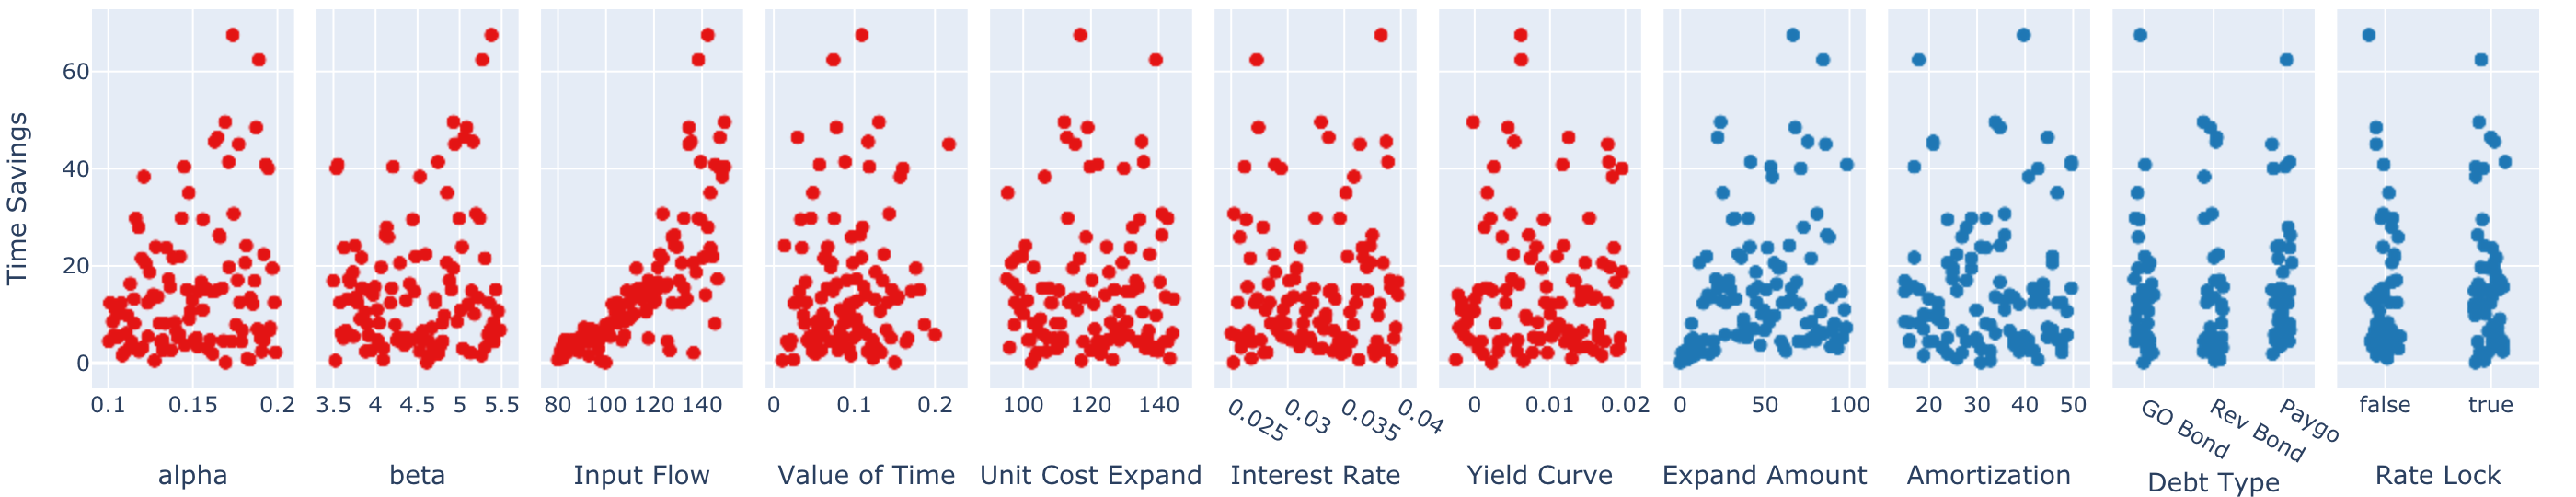

Net Benefits

<xmle.Elem 'img' with 0 children>
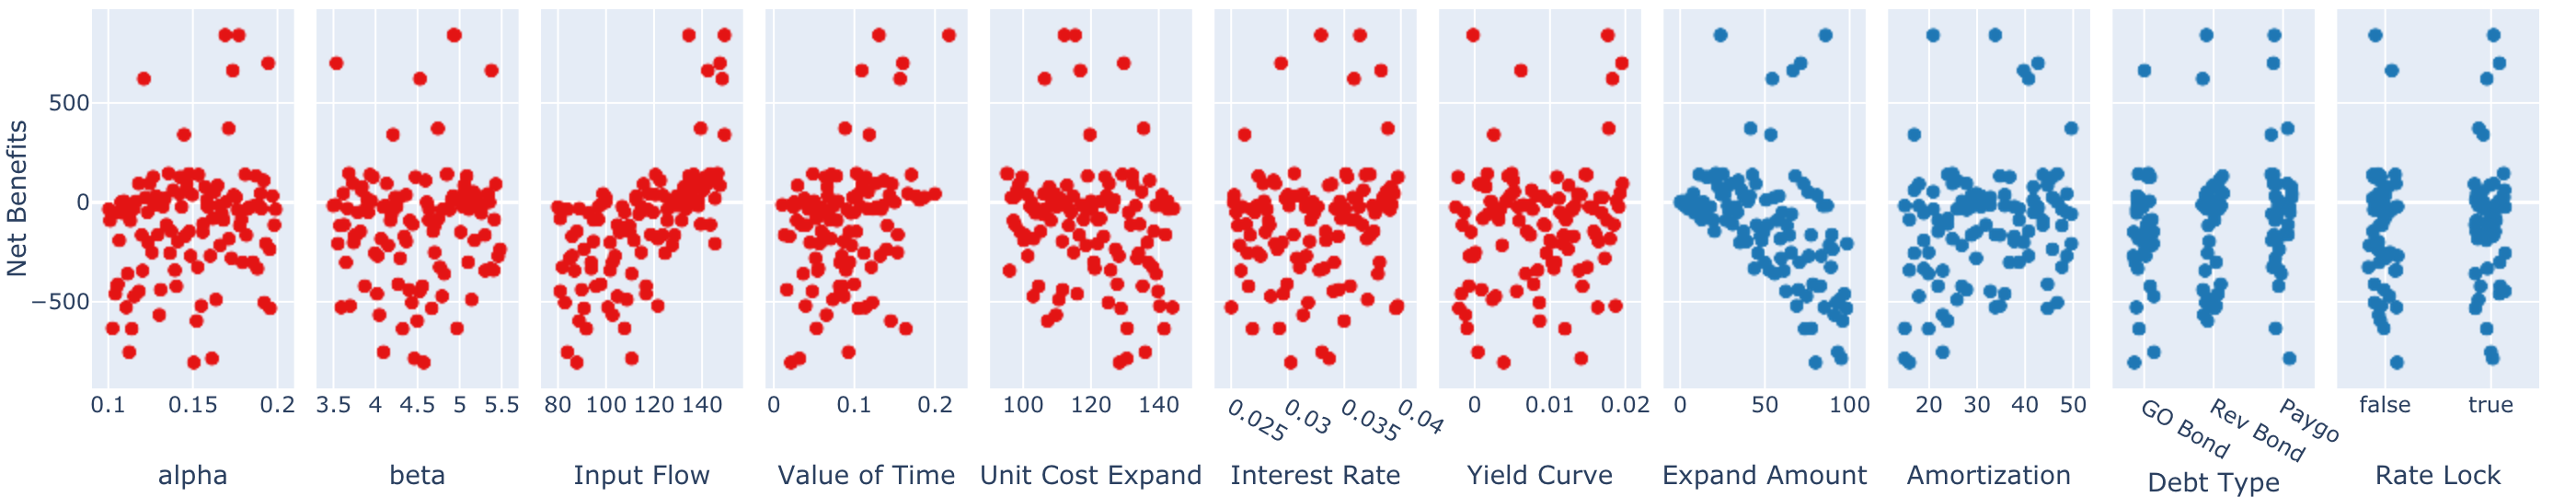

Input Flow

<xmle.Elem 'img' with 0 children>
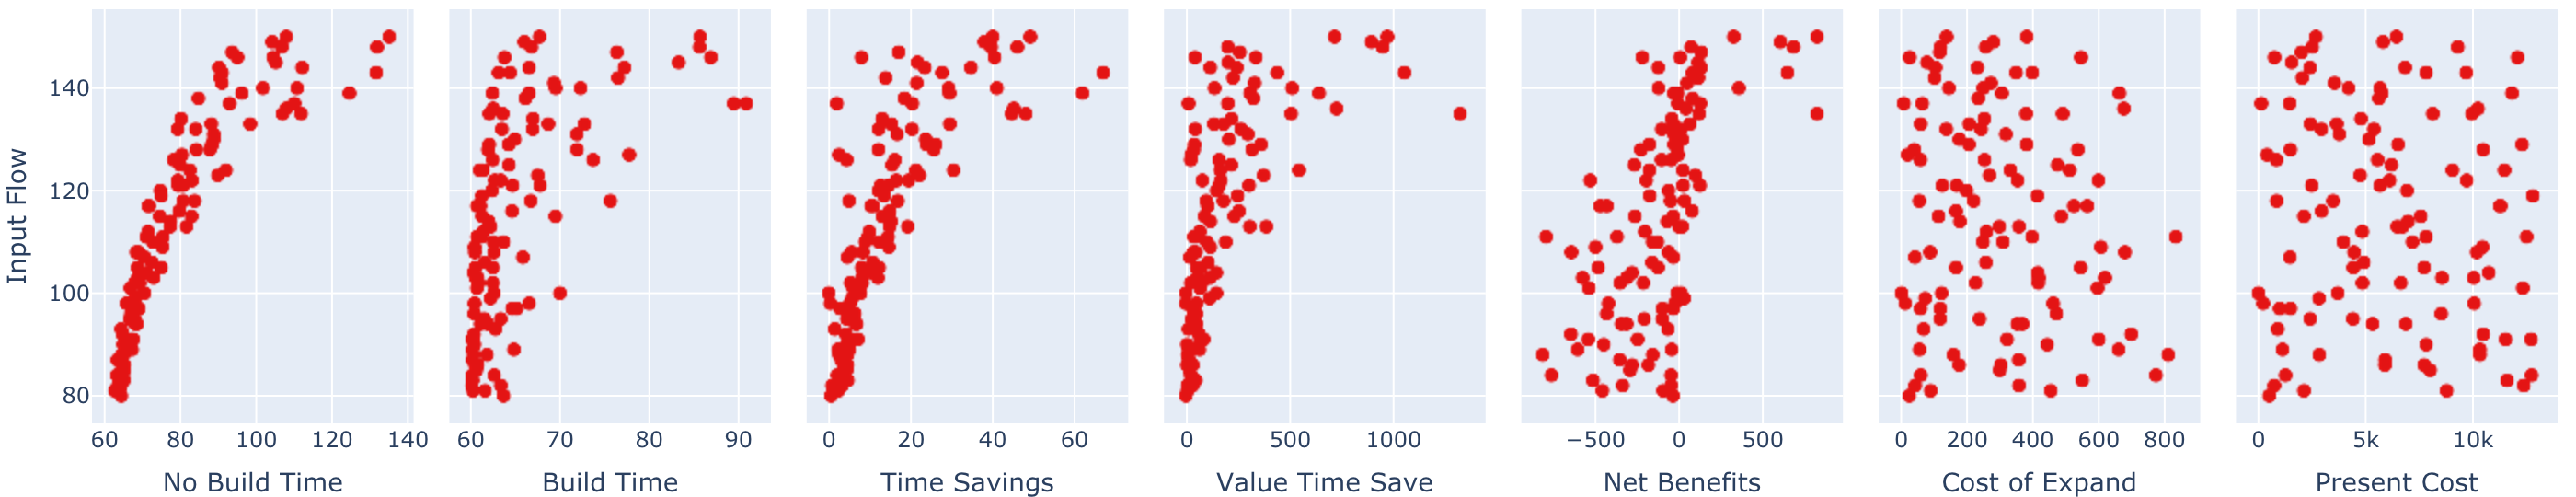

In [28]:
from emat.analysis import display_experiments
display_experiments(road_scope, lhs_results, rows=['time_savings', 'net_benefits', 'input_flow'])

## Scenario Discovery

Scenario discovery in exploratory modeling is focused on finding scenarios that are interesting to the user.  
The process generally begins through the identification of particular outcomes that are "of interest",
and the discovery process that can seek out what factor or combination of factors can result in
those outcomes.

There are a variety of methods to use for scenario discovery.  We illustrate a few here.


### PRIM

Patient rule induction method (PRIM) is an algorithm that operates on a set of data with inputs and outputs.  
It is used for locating areas of an outcome space that are of particular interest, which it does by reducing 
the data size incrementally by small amounts in an iterative process as follows:
    
- Candidate boxes are generated.  These boxes represent incrementally smaller sets of the data.  
  Each box removes a portion of the data based on the levels of a single input variable.
  * For categorical input variables, there is one box generated for each category with each box 
    removing one category from the data set.
  * For integer and continuous variables, two boxes are generated – one box that removes a 
    portion of data representing the smallest set of values for that input variable and another 
    box that removes a portion of data representing the largest set of values for that input.  
    The step size for these variables is controlled by the analyst.
- For each candidate box, the relative improvement in the number of outcomes of interest inside 
  the box is calculated and the candidate box with the highest improvement is selected.
- The data in the selected candidate box replaces the starting data and the process is repeated.

The process ends based on a stopping criteria.  For more details on the algorithm, 
see [Friedman and Fisher (1999)](http://statweb.stanford.edu/~jhf/ftp/prim.pdf) or 
[Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092).

The PRIM algorithm is particularly useful for scenario discovery, which broadly is the process of 
identifying particular scenarios of interest in a large and deeply uncertain dataset.   
In the context of exploratory modeling, scenario discovery is often used to obtain a better understanding 
of areas of the uncertainty space where a policy or collection of policies performs poorly because it is 
often used in tandem with robust search methods for identifying policies that perform well 
([Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092)).

In [29]:
from emat.analysis import prim

In [30]:
x = m.read_experiment_parameters(design_name='lhs_large')
y = m.read_experiment_measures(design_name='lhs_large')['net_benefits']>0

In [31]:
prim_alg = prim.Prim(x, y, threshold=0.4)

In [32]:
box1 = prim_alg.find_box()

[00:21.13] MainProcess/INFO: 5000 points remaining, containing 1395 cases of interest
[00:24.82] MainProcess/INFO: mean: 1.0, mass: 0.0606, coverage: 0.2172043010752688, density: 1.0 restricted_dimensions: 5


In [33]:
box1.tradeoff_selector()

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([0, 1, 1, 1, 1, 1, 1…

In [34]:
box1.inspect(45)

coverage    0.489606
density     0.871173
id                45
mass          0.1568
mean        0.871173
res_dim            5
Name: 45, dtype: object

                         box 45                                            
                            min         max                       qp values
expand_capacity        0.000672   95.018708     [-1.0, 0.06797686844207428]
input_flow           128.000000  150.000000  [4.181142828811809e-168, -1.0]
value_of_time          0.077057    0.236016  [2.2257439851081843e-37, -1.0]
beta                   3.597806    5.499712      [0.1926809470209529, -1.0]
amortization_period   17.000000   50.000000     [0.20016307300821792, -1.0]



### CART

Classification and Regression Trees (CART) can also be used for scenario discovery. 
They partition the explored space (i.e., the scope) into a number of sections, with each partition
being added in such a way as to maximize the difference between observations on each 
side of the newly added partition divider, subject to some constraints.

In [35]:
from ema_workbench.analysis import cart

cart_alg = cart.CART(x,y)
cart_alg.build_tree()

In [36]:
from emat.util.xmle import Show
Show(cart_alg.show_tree(format='svg'))

<xmle.Elem '{http://www.w3.org/2000/svg}svg' with 1 children>

In [37]:
cart_alg.boxes_to_dataframe(include_stats=True)

Box Statistics                           expand_capacity               \
             coverage   density res dim    mass             max          min   
box 1        0.027957  0.150579       2  0.0518         10.9546  0.000671873   
box 2        0.015054  0.057065       2  0.0736         26.2923      10.9546   
box 3        0.000000  0.000000       3  0.2522         99.9857      26.2923   
box 4        0.003584  0.011468       3  0.0872         99.9857      26.2923   
box 5        0.085305  0.449057       2  0.0530         41.2208  0.000671873   
box 6        0.032975  0.104784       2  0.0878         99.9857      41.2208   
box 7        0.083154  0.442748       3  0.0524         42.5986  0.000671873   
box 8        0.025806  0.109091       3  0.0660         99.9857      42.5986   
box 9        0.160573  0.797153       3  0.0562         55.3936  0.000671873   
box 10       0.330466  0.954451       3  0.0966         55.3936  0.000671873   
box 11       0.075269  0.335463       3  0.0626         99.9857      55.3936   
box 12       0.159857  0.735974       3  0.0606         99.9857      55.3936   

       input_flow        value_of_time              
              max    min           max         min  
box 1       112.5     80      0.236016  0.00219361  
box 2       112.5     80      0.236016  0.00219361  
box 3       112.5     80      0.124238  0.00219361  
box 4       112.5     80      0.236016    0.124238  
box 5       122.5  112.5      0.236016  0.00219361  
box 6       122.5  112.5      0.236016  0.00219361  
box 7         150  122.5      0.061168  0.00219361  
box 8         150  122.5      0.061168  0.00219361  
box 9         150  122.5     0.0961739    0.061168  
box 10        150  122.5      0.236016   0.0961739  
box 11      136.5  122.5      0.236016    0.061168  
box 12        150  136.5      0.236016    0.061168

## Robust Search

In [38]:
from emat import Measure

MAXIMIZE = Measure.MAXIMIZE
MINIMIZE = Measure.MINIMIZE

robustness_functions = [
    Measure(
        'Expected Net Benefit', 
        kind=Measure.INFO, 
        variable_name='net_benefits', 
        function=numpy.mean,
    ),
    
    Measure(
        'Probability of Net Loss', 
        kind=MINIMIZE, 
        variable_name='net_benefits', 
        function=lambda x: numpy.mean(x<0),
    ),

    Measure(
        '95%ile Travel Time', 
        kind=MINIMIZE, 
        variable_name='build_travel_time',
        function=functools.partial(numpy.percentile, q=95),
    ),

    Measure(
        '99%ile Present Cost', 
        kind=Measure.INFO, 
        variable_name='present_cost_expansion', 
        function=functools.partial(numpy.percentile, q=99),
    ),

    Measure(
        'Expected Present Cost', 
        kind=Measure.INFO, 
        variable_name='present_cost_expansion', 
        function=numpy.mean,
    ),

]

### Constraints

The robust optimization process solutions can be constrained to only include solutions that 
satisfy certain constraints.  These constraints can be based on the policy lever parameters
that are contained in the core model, the aggregate performance measures identified in 
the list of robustness functions, or some combination of levers and aggregate measures.

In [39]:
from emat import Constraint

The common use case for constraints in robust optimation is imposing requirements
on solution outcomes. For example, we may want to limit our robust search only
to solutions where the expected present cost of the capacity expansion is less
than some particular value (in our example here, 4000).  

In [40]:
constraint_1 = Constraint(
    "Maximum Log Expected Present Cost", 
    outcome_names="Expected Present Cost",
    function=Constraint.must_be_less_than(4000),
)

Our second constraint is based exclusively on an input: the capacity expansion
must be at least 10.  We could also achieve this kind of constraint by changing
the exploratory scope, but we don't necessarily want to change the scope to 
conduct a single robust optimization analysis with a constraint on a policy lever.

In [41]:
constraint_2 = Constraint(
    "Minimum Capacity Expansion", 
    parameter_names="expand_capacity",
    function=Constraint.must_be_greater_than(10),
)

It is also possible to impose constraints based on a combination of inputs and outputs.
For example, suppose that the total funds available for pay-as-you-go financing are
only 1500.  We may thus want to restrict the robust search to only solutions that
are almost certainly within the available funds at 99% confidence (a model output) but only 
if the Paygo financing option is used (a model input).  This kind of constraint can
be created by giving both `parameter_names` and `outcomes_names`, and writing a constraint
function that takes two arguments.

In [42]:
constraint_3 = Constraint(
    "Maximum Paygo", 
    parameter_names='debt_type',
    outcome_names='99%ile Present Cost',
    function=lambda i,j: max(0, j-1500) if i=='Paygo' else 0,
)

In [43]:
robust_results = m.robust_optimize(
    robustness_functions,  
    scenarios=200, 
    nfe=2500, 
    constraints=[
        constraint_1,
        constraint_2,
        constraint_3,
    ],
    evaluator=get_client(),
)

ConvergenceMetrics(children=(FigureWidget({
    'data': [{'fill': 'tonexty',
              'line': {'shape': '…

[00:26.10] MainProcess/INFO: EpsNSGAII starting
[00:26.10] MainProcess/INFO: generation 0: 0/2500 nfe
[00:43.14] MainProcess/INFO: generation 5: 500/2500 nfe
[00:59.45] MainProcess/INFO: generation 10: 1000/2500 nfe
[01:15.15] MainProcess/INFO: generation 15: 1500/2500 nfe
[01:30.76] MainProcess/INFO: generation 20: 2000/2500 nfe
[01:46.70] MainProcess/INFO: EpsNSGAII finished; Total NFE: 2500, Elapsed Time: 0:01:20.604116
[01:46.70] MainProcess/INFO: optimization completed, found 3 solutions
[01:46.72] MainProcess/INFO: performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[01:46.82] MainProcess/INFO: experiments finished
[01:46.82] MainProcess/INFO: performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[01:46.92] MainProcess/INFO: experiments finished
[01:46.92] MainProcess/INFO: performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[01:47.04] MainProcess/INFO: experiments finished


The robust_results include all the non-dominated solutions which satisfy the contraints that are found.
Note that robust optimization is generally a hard problem, and the algorithm may need to run for
a very large number of iterations in order to arrive at a good set of robust solutions.

In [44]:
robust_results.par_coords()

ParCoordsViewer(children=(FigureWidget({
    'data': [{'dimensions': [{'label': '(L) Expand Amount',
         …

## Creating a Meta-Model

In [45]:
mm = m.create_metamodel_from_design('lhs')
mm

<emat.PythonCoreModel "EMATMeta", metamodel_id=1 with 2 constants, 7 uncertainties, 4 levers, 7 measures>

To demonstrate the performance of the meta-model, we can create an
alternate design of experiments.  Note that to get different random values,
we set the `random_seed` argument to something other than the default value.

In [46]:
design2 = design_experiments(road_scope, db=emat_db, n_samples_per_factor=10, sampler='lhs', random_seed=2)

In [47]:
design2_results = mm.run_experiments(design2)
design2_results.head()

[01:58.93] MainProcess/INFO: performing 110 scenarios/policies * 1 model(s) = 110 experiments
[01:58.94] MainProcess/INFO: performing experiments sequentially
[01:59.07] MainProcess/INFO: 11 cases completed
[01:59.17] MainProcess/INFO: 22 cases completed
[01:59.27] MainProcess/INFO: 33 cases completed
[01:59.36] MainProcess/INFO: 44 cases completed
[01:59.46] MainProcess/INFO: 55 cases completed
[01:59.56] MainProcess/INFO: 66 cases completed
[01:59.66] MainProcess/INFO: 77 cases completed
[01:59.76] MainProcess/INFO: 88 cases completed
[01:59.86] MainProcess/INFO: 99 cases completed
[01:59.95] MainProcess/INFO: 110 cases completed
[01:59.95] MainProcess/INFO: experiments finished


,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,free_flow_time,initial_capacity,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
5111,0.113526,5.344274,142,0.087901,131.820315,0.033177,0.000400,75.218326,48,GO Bond,True,60,100,104.148940,63.227772,37.727806,597.583011,25.776226,291.912344,10016.621044
5112,0.112148,4.579477,132,0.058116,133.709154,0.034554,0.005657,24.154443,29,Rev Bond,False,60,100,83.989605,70.168861,14.298242,112.732487,-151.094933,175.930257,3185.499400
5113,0.119548,4.353462,148,0.040388,95.650097,0.032211,0.013589,84.003562,32,Rev Bond,False,60,100,100.157326,64.147316,49.138519,499.169212,-152.588280,584.743727,10448.228986
5114,0.102516,4.490051,150,0.204260,136.919028,0.028362,-0.001315,51.580600,42,GO Bond,False,60,100,98.814358,67.972440,30.051317,1496.210216,378.793370,296.909451,6639.409293
5115,0.140831,5.024638,120,0.067252,115.270765,0.033885,0.009138,74.351908,17,Rev Bond,False,60,100,81.164331,61.867655,18.717260,163.665253,-289.170556,722.880014,8767.426522


In [48]:
mm.function.cross_val_scores()

no_build_travel_time          0.995396
build_travel_time             0.976807
time_savings                  0.893823
value_of_time_savings         0.854504
net_benefits                  0.600039
cost_of_capacity_expansion    0.862780
present_cost_expansion        0.890449
dtype: float64

### Compare Core vs Meta Model Results

We can generate a variety of plots to compare the distribution of meta-model outcomes
on the new design against the original model's results.

In [49]:
from emat.viz.scatter import scatter_graph

scatter_graph(
    X=[ design2_results['input_flow'],
        lhs_results['input_flow'] ],
    Y=[ design2_results['time_savings'],
        lhs_results['time_savings'],  ],
    legend_labels=[ 'meta-model',
                    'core model',  ]
)

FigureWidget({
    'data': [{'marker': {'opacity': 1.0, 'sizemode': 'area', 'sizeref': 0.0},
              'mo…

In [50]:
scatter_graph(
    X=[ design2_results['no_build_travel_time'],
        lhs_results['no_build_travel_time'], ],
    Y=[ design2_results['time_savings'],
        lhs_results['time_savings'], ],
    legend_labels=[ 'meta-model',
                    'core model', ]
)

FigureWidget({
    'data': [{'marker': {'opacity': 1.0, 'sizemode': 'area', 'sizeref': 0.0},
              'mo…

In [51]:
scatter_graph(
    X=[ design2_results['expand_capacity'],
        lhs_results['expand_capacity'], ],
    Y=[ design2_results['present_cost_expansion'],
        lhs_results['present_cost_expansion'], ],
    legend_labels=[ 'meta-model',
                    'core model', ]
)

FigureWidget({
    'data': [{'marker': {'opacity': 1.0, 'sizemode': 'area', 'sizeref': 0.0},
              'mo…